In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

/home/yoshihisa_furusawa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
import matplotlib.pylab as plt

In [5]:
def re_normalization(input_array, rho, xp=np):
    input_array = xp.array(input_array.array, dtype=xp.float32)
    return chainer.Variable((input_array/xp.linalg.norm(input_array))*rho)

def normalize(x):
    return (x - x.min())/(x.max() - x.min())

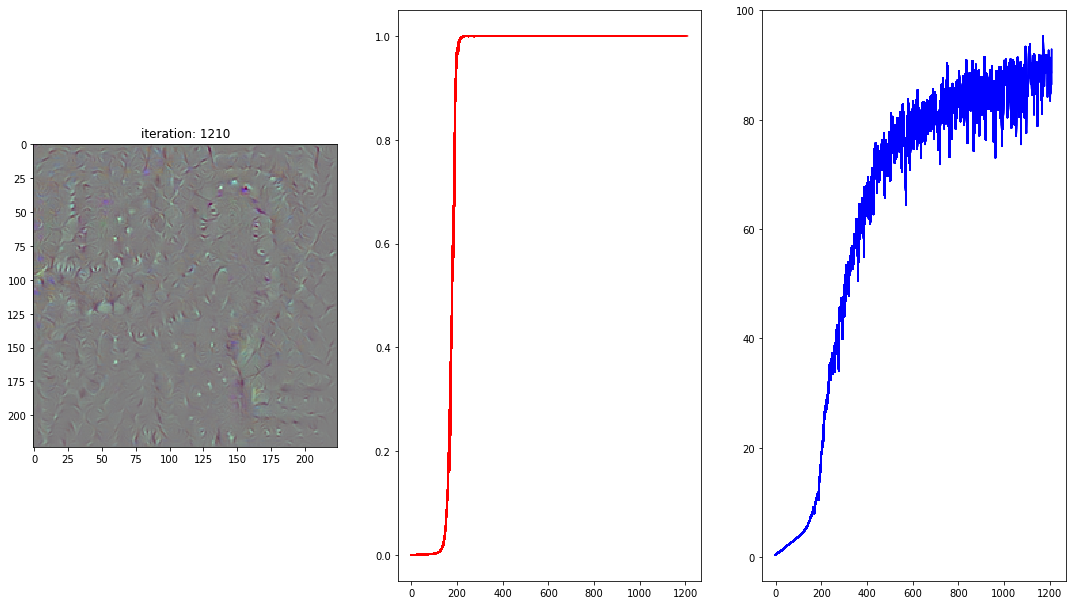

In [6]:
import cupy as cp

model = L.ResNet50Layers()
model.to_gpu()

cp.random.seed(10)
balse_line_img = np.random.uniform(low=0, high=1*255, size=(224,224,3)).astype(cp.float32)
#balse_line_img = cp.random.random(size=(224,224,3)).astype(cp.float32)
balse_line_img = chainer.links.model.vision.resnet.prepare(balse_line_img)[None]

input_img = chainer.Variable(balse_line_img.copy())
target_class = 256
learning_rate = 10
lambda_rate = 5
iteration = 100

activete_list = []
pred_list = []
fig = plt.figure()
upper_thresh = 0

i = -1
while True:
    i += 1
    if (i %20 == 0) & (i != 0):
        print(i)
    
    with chainer.using_config('train', False):
        input_img = re_normalization(input_img, rho=125, xp=cp)
        pred = model(input_img, layers=['fc6'])['fc6']
        pred_after_softmax = F.softmax(pred)[:, target_class]
        activate_value = pred[0, target_class]
        model.cleargrads()
        maximum_activete = activate_value - lambda_rate*F.mean(F.square(input_img))
        maximum_activete.backward(retain_grad=True)
        
        if pred_after_softmax[0].array > 0.99:
            upper_thresh += 1
        
        pred_list.append(chainer.cuda.to_cpu(pred_after_softmax.array))
        activete_list.append(chainer.cuda.to_cpu(activate_value.array))
        input_img += learning_rate*input_img.grad
        
        if i % 5 == 0:
            clear_output(wait = True)
            fig.set_size_inches(18.5, 10.5)
            plt.subplot(1,3,1)
            plt.title("iteration: " + str(i))
            plt.imshow(normalize(chainer.cuda.to_cpu(input_img[0].transpose(1,2,0).array)))
            
            plt.subplot(1,3,2)
            plt.plot(np.arange(len(pred_list)), pred_list, c="r")
            
            plt.subplot(1,3,3)
            plt.plot(np.arange(len(activete_list)), activete_list, c="b")
            display(fig)

        if upper_thresh >= 1000:
            clear_output(wait = True)
            break

In [32]:
import pandas as pd

In [29]:
with open("/home/yoshihisa_furusawa/Desktop/visualizing_with_deep_learning-master/imagenet1000_classification_list.txt") as f:
    data = f.readlines()

In [30]:
data[target_class]

" 10: 'brambling, Fringilla montifringilla',\n"